In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import os

# Loading data

In [ ]:
# data_dir_1 = "/home/hxastur/vscode_projects/ieee-cis-fraud-detection/competition_data"
# data_dir_2 = "/home/hxastur/vscode-projects/ieee-cis-fraud-detection/competition_data"
# data_kaggle = '/kaggle/input/ieee-fraud-detection'

data_dir = '/kaggle/input/ieee-fraud-detection'
data_dir_zip = f"{data_dir}/ieee-fraud-detection.zip"

In [ ]:
# !kaggle competitions download -c ieee-fraud-detection -p {data_dir}
# !unzip {data_dir_zip} -d {data_dir}

In [ ]:
train_identity_path = os.path.join(data_dir, "train_identity.csv")
train_transaction_path = os.path.join(data_dir, "train_transaction.csv")
test_identity_path = os.path.join(data_dir, "test_identity.csv")
test_transaction_path = os.path.join(data_dir, "test_transaction.csv")

In [ ]:
train_identity = pl.read_csv(train_identity_path)
train_transaction = pl.read_csv(train_transaction_path)
test_identity = pl.read_csv(test_identity_path)
test_transaction = pl.read_csv(test_transaction_path)

# General information

In [ ]:
train_identity.head()

In [ ]:
train_transaction.head()

In [10]:
print(
    f"Shapes\ntrain_identity: {train_identity.shape}\ntrain_transaction: {train_transaction.shape}\ntest_identity: {test_identity.shape}\ntest_transaction: {test_transaction.shape}"
)

Shapes
train_identity: (144233, 41)
train_transaction: (590540, 394)
test_identity: (141907, 41)
test_transaction: (506691, 393)


## Merging transaction and identity df

In [11]:
train_transaction["TransactionID"].is_unique().all(), test_transaction[
    "TransactionID"
].is_unique().all()

(True, True)

In [12]:
(
    train_transaction
    .join(train_identity.select('TransactionID').unique(),on='TransactionID',how='inner')
    .height,
    test_transaction
    .join(test_identity.select('TransactionID').unique(),on='TransactionID',how='inner')
    .height
)


(144233, 141907)

In [13]:
train_df = train_transaction.join(train_identity,on='TransactionID',how='left')
test_df=test_transaction.join(test_identity,on='TransactionID',how='left')
print(f"Dataset sizes | train: {train_df.shape}, test: {test_df.shape}")

Dataset sizes | train: (590540, 434), test: (506691, 433)


In [82]:
one_value_cols_train = [col for col in train_df.columns if train_df[col].n_unique() <= 1]
one_value_cols_test = [col for col in test_df.columns if test_df[col].n_unique() <= 1]

print(
    f"Number of columns in train with one unique value: {len(one_value_cols_train)}\nNumber of columns in test with one unique value: {len(one_value_cols_test)}"
)
print(one_value_cols_train, one_value_cols_test)

Number of columns in train with one unique value: 0
Number of columns in test with one unique value: 1
[] ['V107']



[Data description](https://www.kaggle.com/competitions/ieee-fraud-detection/discussion/101203)

---

**Transaction Table**

TransactionDT: timedelta from a given reference datetime (not an actual timestamp)

TransactionAMT: transaction payment amount in USD

ProductCD: product code, the product for each transaction

card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.

addr: address

dist: distance

P_ and (R__) emaildomain: purchaser and recipient email domain

C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

D1-D15: timedelta, such as days between previous transaction, etc.

M1-M9: match, such as names on card and address, etc.

Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Categorical Features: ProductCD card1 - card6 addr1, addr2 P_emaildomain R_emaildomain M1 - M9

---

**Identity Table**

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. They're collected by Vesta’s fraud protection system and digital security partners. (The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

Categorical Features: DeviceType DeviceInfo id_12 - id_38

# Transaction table

## Continuous Features - Transaction

**TransactionAmt**

In [14]:
train_transaction["TransactionAmt"].describe()

statistic,value
str,f64
"""count""",590540.0
"""null_count""",0.0
"""mean""",135.027176
"""std""",239.162522
"""min""",0.251
"""25%""",43.321
"""50%""",68.78
"""75%""",125.0
"""max""",31937.391


**TransactionDT**

In [80]:
train_transaction["TransactionDT"].describe()

statistic,value
str,f64
"""count""",590540.0
"""null_count""",0.0
"""mean""",7.3723e6
"""std""",4.6172e6
"""min""",86400.0
"""25%""",3.027065e6
"""50%""",7.306535e6
"""75%""",1.1246605e7
"""max""",1.5811131e7


In [81]:
print(
    f"TransactionDT in days\n\nTRAIN\nMin: {train_transaction['TransactionDT'].min()/(60*60*24)}\nMax: {train_transaction['TransactionDT'].max()/(60*60*24)}"
)
print(
    f"TEST\nMin: {test_transaction['TransactionDT'].min()/(60*60*24)}\nMax: {test_transaction['TransactionDT'].max()/(60*60*24)}"
)
print(
    f"\nGap: {test_transaction['TransactionDT'].min()/(60**2*24) - train_transaction['TransactionDT'].max()/(60**2*24)}"
)

TransactionDT in days

TRAIN
Min: 1.0
Max: 182.99920138888888
TEST
Min: 213.00027777777777
Max: 395.99936342592594

Gap: 30.00107638888889


Text(0.5, 1.0, 'Distributeion of transaction dates')

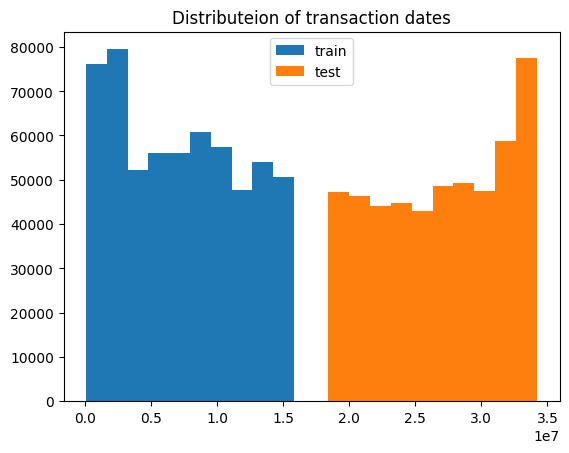

In [86]:
plt.hist(train_df["TransactionDT"], label="train")
plt.hist(test_df["TransactionDT"], label="test")
plt.legend()
plt.title("Distributeion of transaction dates")

time-based split for validation: https://www.kaggle.com/code/robikscube/ieee-fraud-detection-first-look-and-eda

## Categorical Features - Transaction


In [15]:
train_transaction["ProductCD"].value_counts()

ProductCD,count
str,u32
"""R""",37699
"""H""",33024
"""W""",439670
"""S""",11628
"""C""",68519


### isFraud

In [20]:
print(f"Percentage of Fraud: {train_transaction['isFraud'].mean():0.2}")

Percentage of Fraud: 0.035


**id_01 - id_11**

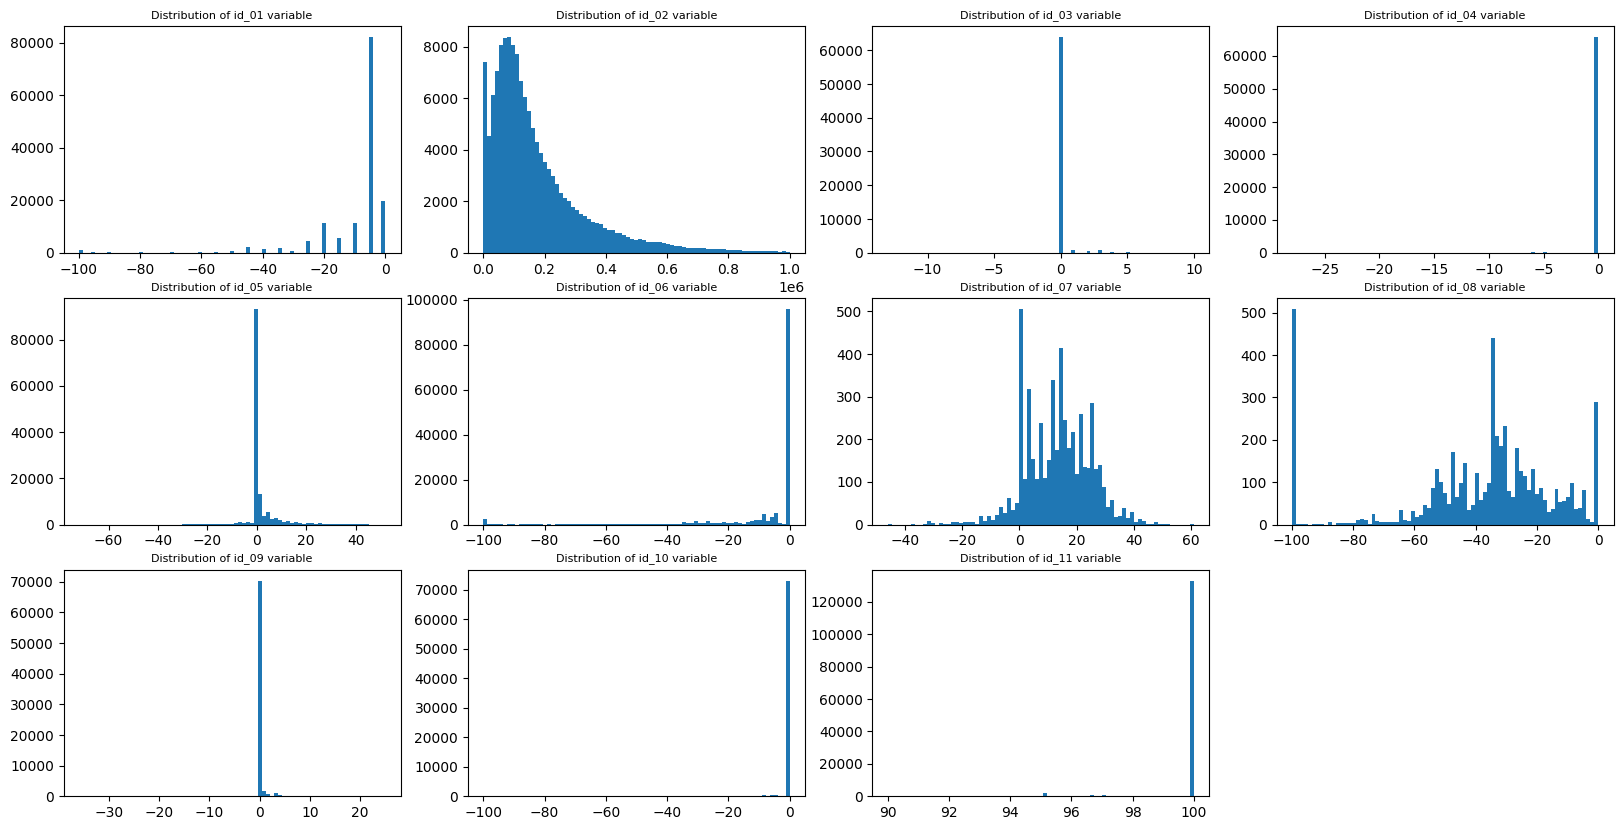

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 10))
id_names = [f"id_0{i}" if i < 10 else f"id_{i}" for i in range(1, 12)]
idx = 0
for i in range(3):
    for j in range(4):
        if idx >= len(id_names):
            axes[i][j].set_visible(False)
            break
        var_name = id_names[idx]
        axes[i][j].hist(train_df[var_name], bins=77)
        axes[i][j].set_title(f"Distribution of {var_name} variable", fontsize=8)
        idx += 1

In [83]:
counts = train_df["id_03"].value_counts().sort("count", descending=True)

total = train_df.height  
counts_normalized = counts.with_columns(
    (pl.col("count") / total).alias("proportion")
)

print(counts_normalized.head())

shape: (5, 3)
┌───────┬────────┬────────────┐
│ id_03 ┆ count  ┆ proportion │
│ ---   ┆ ---    ┆ ---        │
│ f64   ┆ u32    ┆ f64        │
╞═══════╪════════╪════════════╡
│ null  ┆ 524216 ┆ 0.887689   │
│ 0.0   ┆ 63903  ┆ 0.108211   │
│ 1.0   ┆ 863    ┆ 0.001461   │
│ 3.0   ┆ 668    ┆ 0.001131   │
│ 2.0   ┆ 421    ┆ 0.000713   │
└───────┴────────┴────────────┘


In [84]:
counts = train_df["id_04"].value_counts().sort("count", descending=True)

total = train_df.height
counts_normalized = counts.with_columns(
    (pl.col("count") / total).alias("proportion")
)

print(counts_normalized.head())

shape: (5, 3)
┌───────┬────────┬────────────┐
│ id_04 ┆ count  ┆ proportion │
│ ---   ┆ ---    ┆ ---        │
│ f64   ┆ u32    ┆ f64        │
╞═══════╪════════╪════════════╡
│ null  ┆ 524216 ┆ 0.887689   │
│ 0.0   ┆ 65739  ┆ 0.11132    │
│ -5.0  ┆ 132    ┆ 0.000224   │
│ -6.0  ┆ 98     ┆ 0.000166   │
│ -8.0  ┆ 64     ┆ 0.000108   │
└───────┴────────┴────────────┘


In [24]:
counts = train_df["id_11"].value_counts().sort("count", descending=True)

total = train_df.height 
counts_normalized = counts.with_columns(
    (pl.col("count") / total).alias("proportion")
)

print(counts_normalized.head(10))

shape: (10, 3)
┌───────────┬────────┬────────────┐
│ id_11     ┆ count  ┆ proportion │
│ ---       ┆ ---    ┆ ---        │
│ f64       ┆ u32    ┆ f64        │
╞═══════════╪════════╪════════════╡
│ null      ┆ 449562 ┆ 0.761273   │
│ 100.0     ┆ 133162 ┆ 0.225492   │
│ 95.080002 ┆ 1231   ┆ 0.002085   │
│ 95.160004 ┆ 754    ┆ 0.001277   │
│ 97.120003 ┆ 440    ┆ 0.000745   │
│ 96.669998 ┆ 333    ┆ 0.000564   │
│ 95.650002 ┆ 286    ┆ 0.000484   │
│ 96.190002 ┆ 241    ┆ 0.000408   │
│ 94.290001 ┆ 228    ┆ 0.000386   │
│ 93.550003 ┆ 204    ┆ 0.000345   │
└───────────┴────────┴────────────┘


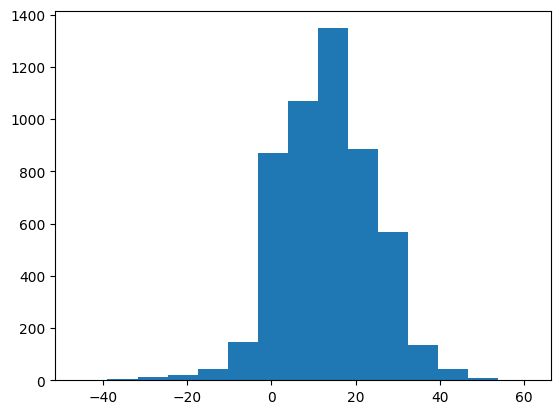

In [25]:
plt.hist(train_df["id_07"], bins=15)
plt.show()

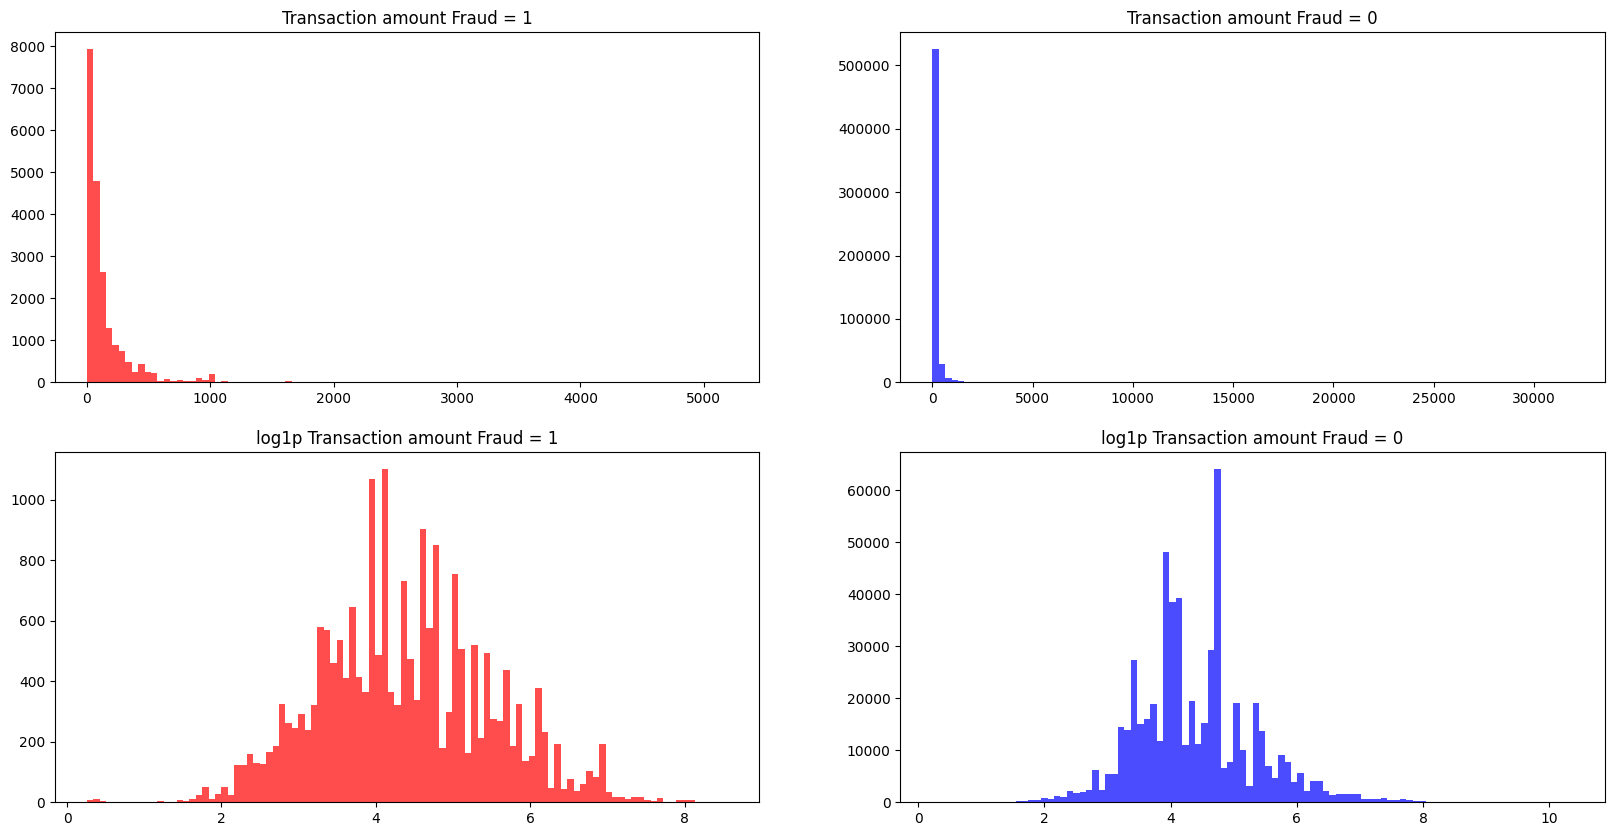

In [27]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))

train_fraud_1 = train_transaction.filter(pl.col('isFraud')==1)['TransactionAmt'].to_numpy()
train_fraud_0 = train_transaction.filter(pl.col('isFraud')==0)['TransactionAmt'].to_numpy()

ax1.hist(train_fraud_1,bins=100,color='red',alpha=0.7)
ax1.set_title("Transaction amount Fraud = 1")

ax2.hist(train_fraud_0,bins=100,color='blue',alpha=0.7)
ax2.set_title("Transaction amount Fraud = 0")

ax3.hist(np.log1p(train_fraud_1),bins=100,color='red',alpha=0.7)
ax3.set_title("log1p Transaction amount Fraud = 1")

ax4.hist(np.log1p(train_fraud_0),bins=100,color='blue',alpha=0.7)
ax4.set_title("log1p Transaction amount Fraud = 0")

plt.show()

Text(0, 0.5, 'Frequency')

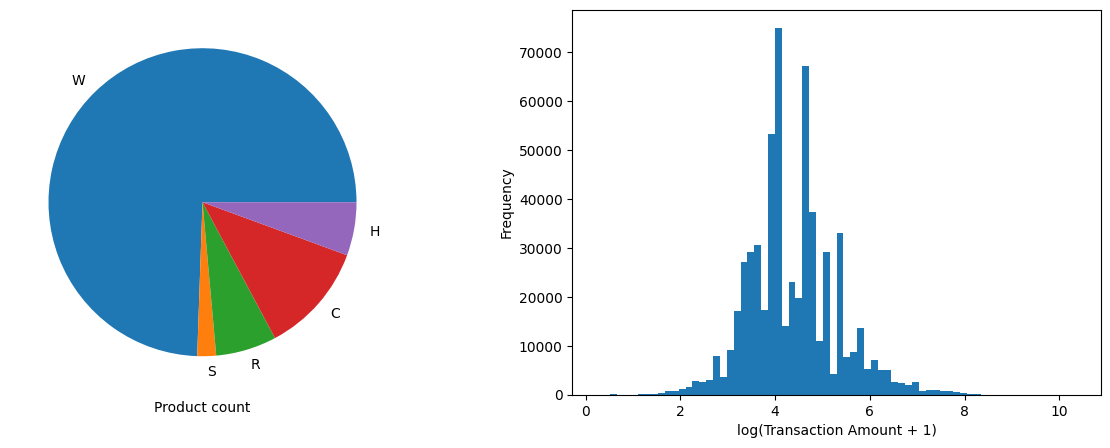

In [32]:
fix, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))

product_count = train_transaction["ProductCD"].value_counts()
counts = product_count['count'].to_numpy()
labels = product_count['ProductCD'].to_numpy()

axes[0].pie(counts, labels=labels)
axes[0].set_xlabel("Product count")

log_amt = np.log1p(train_transaction["TransactionAmt"].to_numpy())
axes[1].hist(log_amt, bins=70)
axes[1].set_xlabel("log(Transaction Amount + 1)")
axes[1].set_ylabel("Frequency")

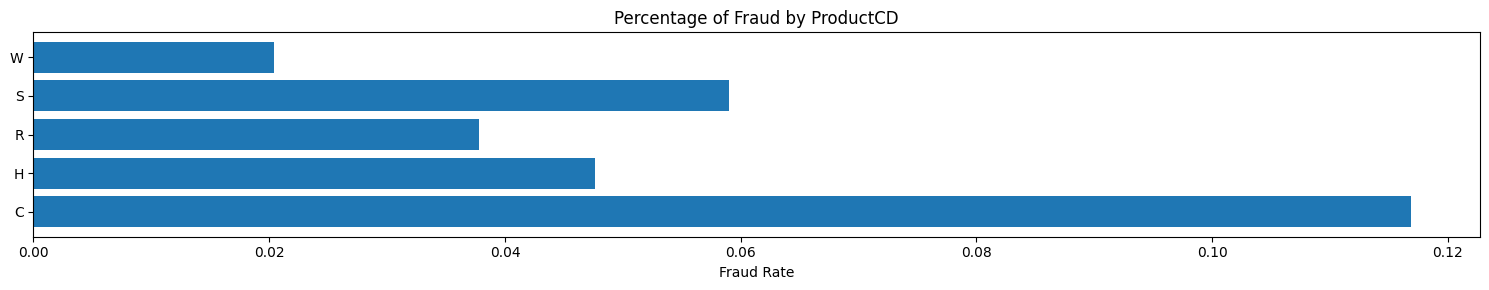

In [33]:
fraud_by_product = (
    train_transaction
    .group_by("ProductCD")
    .agg(pl.col("isFraud").mean())
    .sort("ProductCD")  # аналог sort_index() — сортируем по значению категории
)

# Извлекаем данные как numpy массивы для matplotlib
product_labels = fraud_by_product["ProductCD"].to_numpy()
fraud_rates = fraud_by_product["isFraud"].to_numpy()

# Горизонтальная гистограмма
plt.figure(figsize=(15, 3))
plt.barh(product_labels, fraud_rates)
plt.title("Percentage of Fraud by ProductCD")
plt.xlabel("Fraud Rate")
plt.tight_layout()
plt.show()

In [45]:
card_cols = [c for c in train_transaction.columns if 'card' in c]
train_transaction[card_cols].head()

card1,card2,card3,card4,card5,card6
i64,f64,f64,str,f64,str
13926,null,150.0,"""discover""",142.0,"""credit"""
2755,404.0,150.0,"""mastercard""",102.0,"""credit"""
4663,490.0,150.0,"""visa""",166.0,"""debit"""
18132,567.0,150.0,"""mastercard""",117.0,"""debit"""
4497,514.0,150.0,"""mastercard""",102.0,"""credit"""


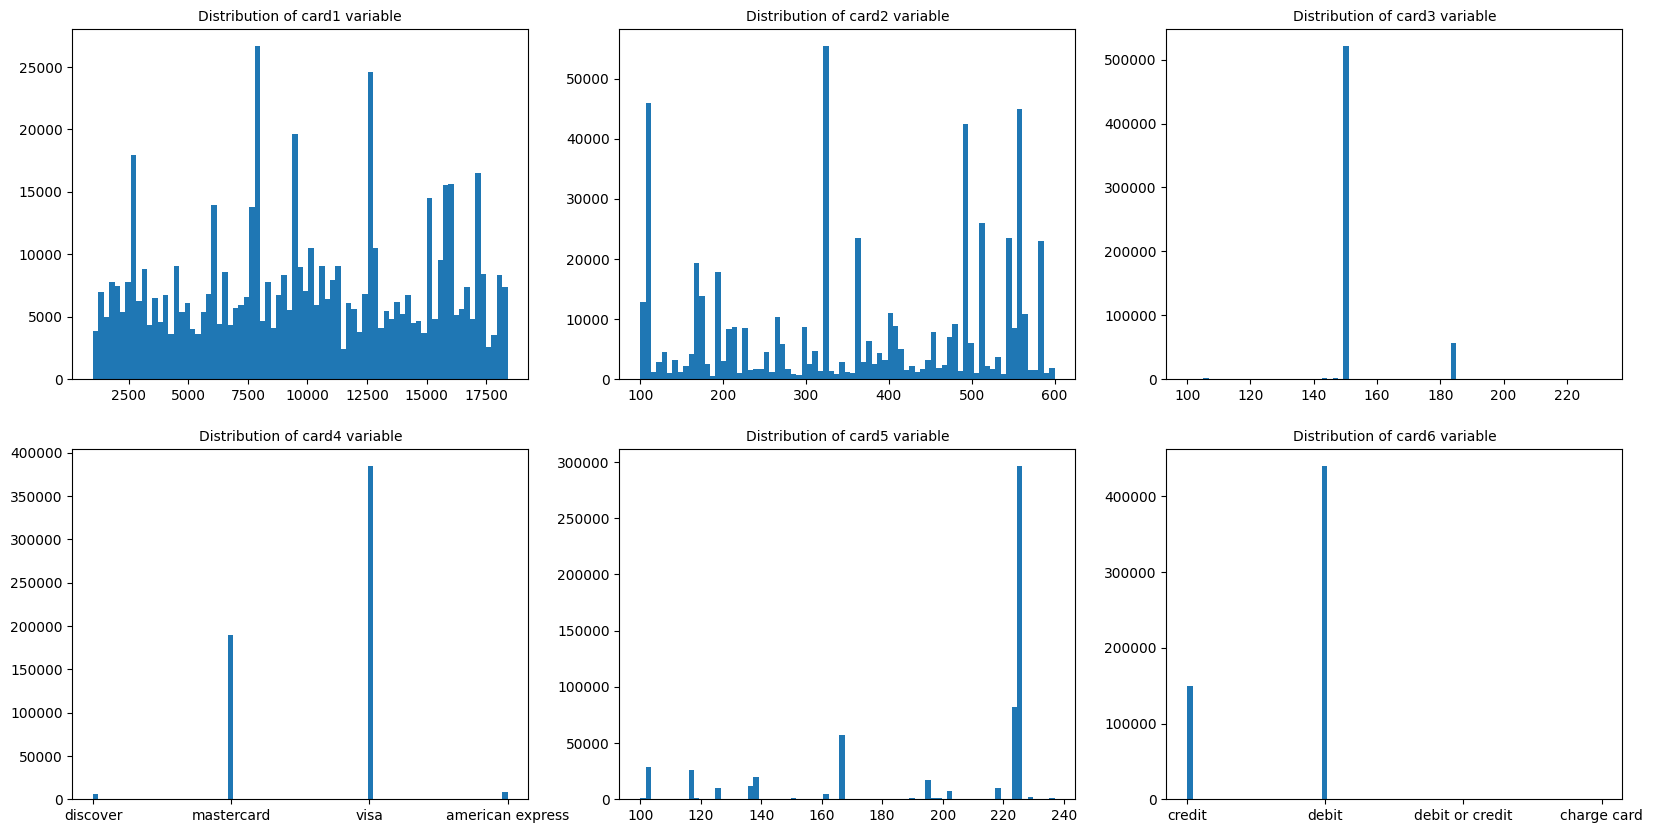

In [59]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
idx = 0
for i in range(2):
    for j in range(3):
        if idx >= len(card_cols):
            axes[i][j].set_visible(False)
            continue
        var_name = card_cols[idx]
        values = train_transaction[var_name].drop_nulls()
        axes[i][j].hist(values, bins=77)
        axes[i][j].set_title(f"Distribution of {var_name} variable", fontsize=10)
        idx += 1

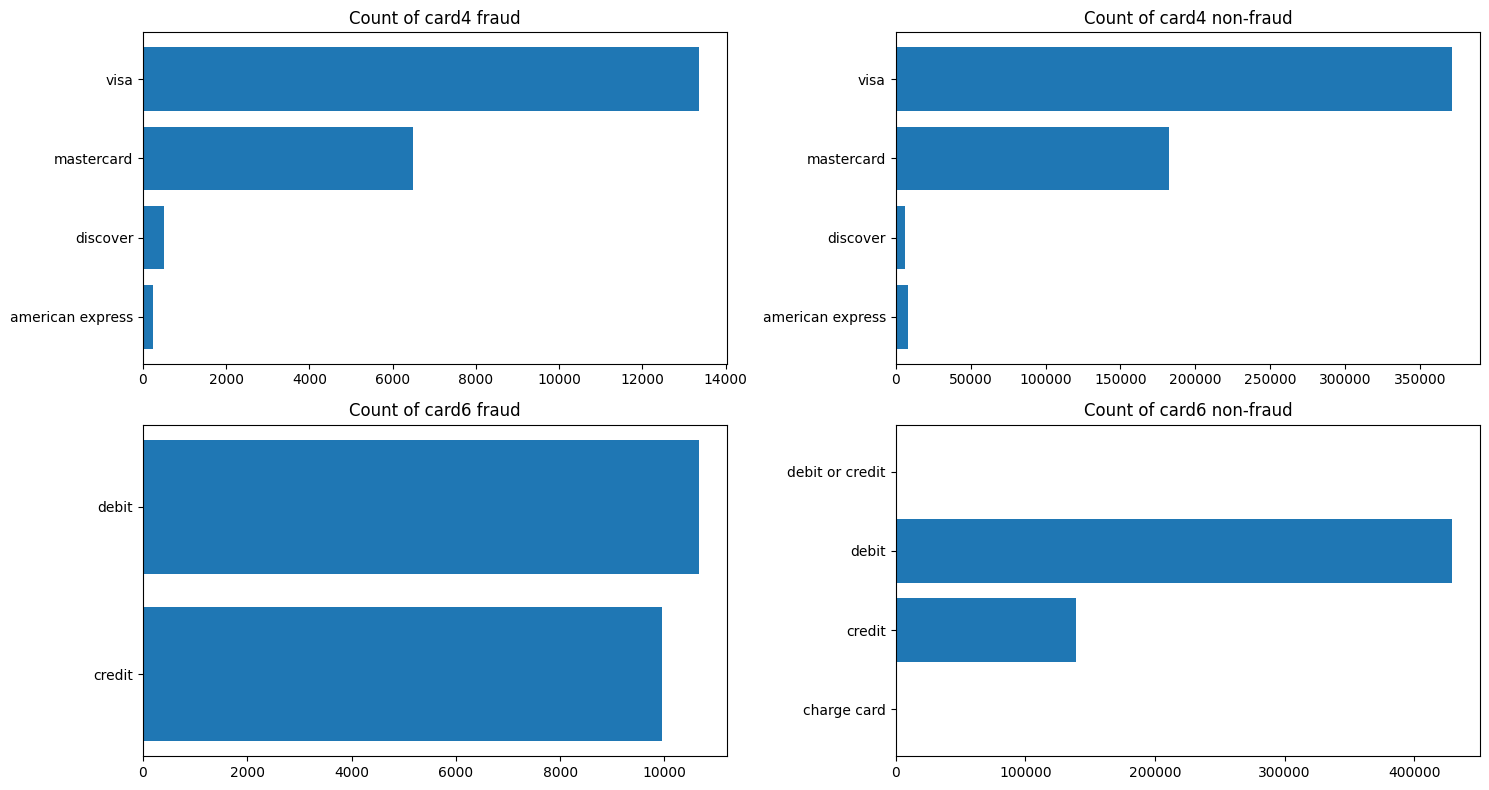

In [68]:
# Фильтрация по isFraud
train_transaction_fr = train_transaction.filter(pl.col("isFraud") == 1)
train_transaction_nofr = train_transaction.filter(pl.col("isFraud") == 0)

# Подсчёт количества по категориям
card4_fraud = (
    train_transaction_fr
    .group_by("card4")
    .agg(pl.len().alias("count"))
    .sort("card4")
    .drop_nulls()
)

card4_nofraud = (
    train_transaction_nofr
    .group_by("card4")
    .agg(pl.len().alias("count"))
    .sort("card4")
    .drop_nulls()
)

card6_fraud = (
    train_transaction_fr
    .group_by("card6")
    .agg(pl.len().alias("count"))
    .sort("card6")
    .drop_nulls()
)

card6_nofraud = (
    train_transaction_nofr
    .group_by("card6")
    .agg(pl.len().alias("count"))
    .sort("card6")
    .drop_nulls()
)

# Отрисовка
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8))

# card4 — fraud
ax1.barh(card4_fraud["card4"].to_numpy(), card4_fraud["count"].to_numpy())
ax1.set_title("Count of card4 fraud")

# card4 — non-fraud
ax2.barh(card4_nofraud["card4"].to_numpy(), card4_nofraud["count"].to_numpy())
ax2.set_title("Count of card4 non-fraud")

# card6 — fraud
ax3.barh(card6_fraud["card6"].to_numpy(), card6_fraud["count"].to_numpy())
ax3.set_title("Count of card6 fraud")

# card6 — non-fraud
ax4.barh(card6_nofraud["card6"].to_numpy(), card6_nofraud["count"].to_numpy())
ax4.set_title("Count of card6 non-fraud")

plt.tight_layout()
plt.show()

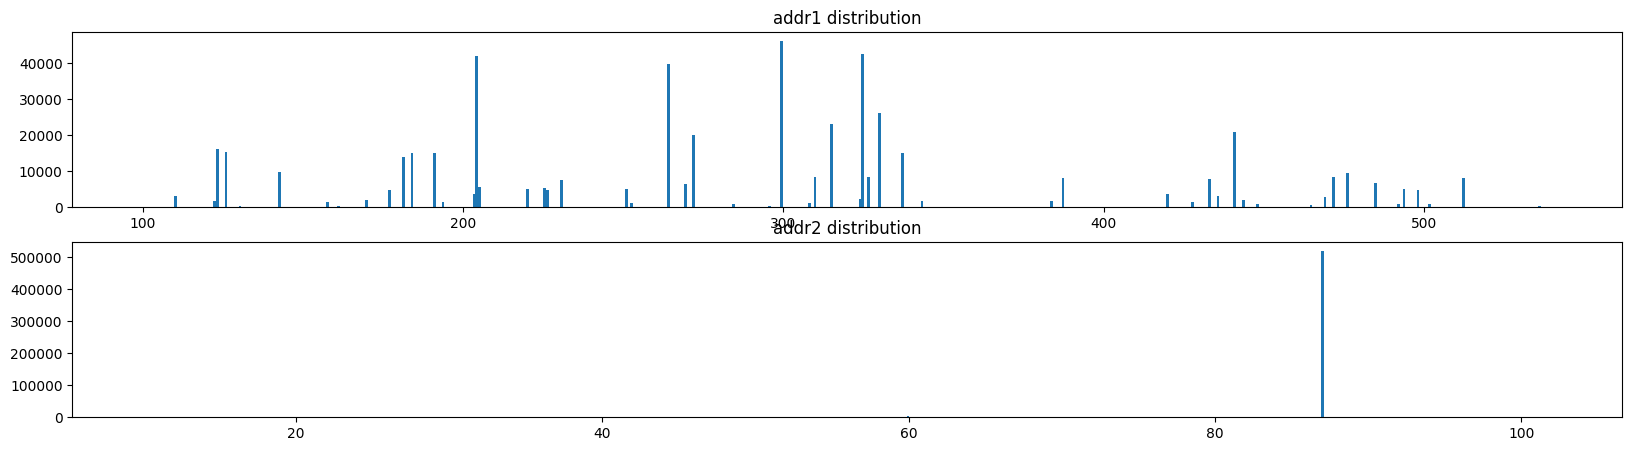

In [74]:
fix, (ax1,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(20,5))

ax1.hist(train_transaction.select('addr1'),bins=500)
ax1.set_title('addr1 distribution')

ax2.hist(train_transaction.select('addr2'),bins=500)
ax2.set_title('addr2 distribution')

plt.show()

## Categorical Features - Identity

### DeviceType

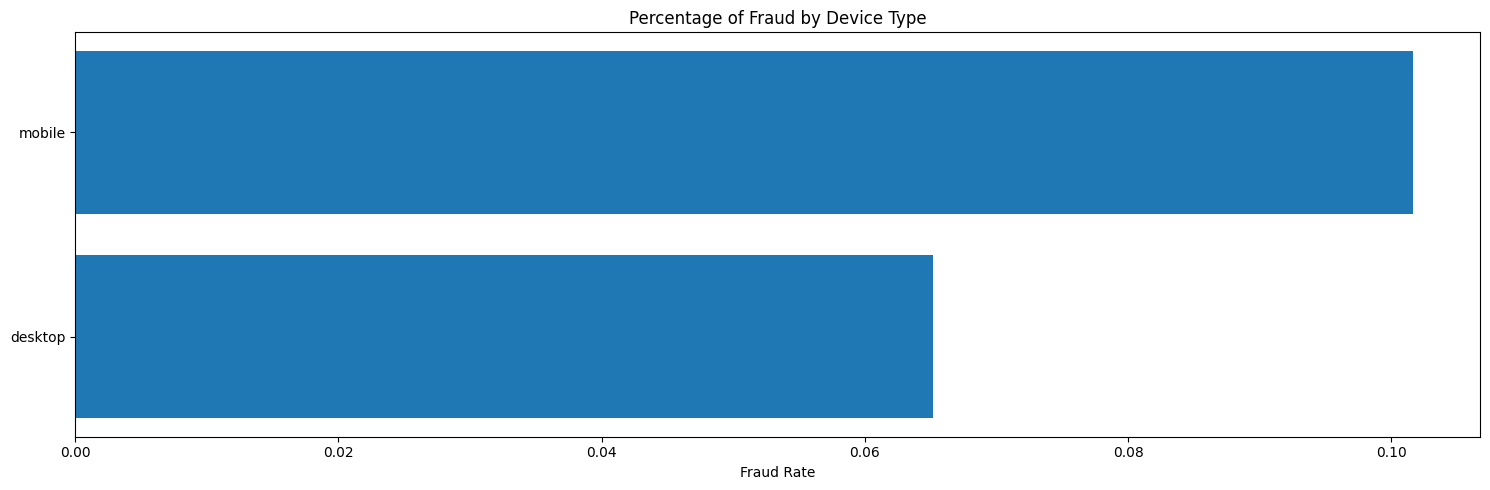

In [79]:
fraud_by_device = (
    train_df
    .group_by("DeviceType")
    .agg(pl.col("isFraud").mean())
    .sort("isFraud")  # аналог sort_values() — сортируем по значению доли
    .drop_nulls()
)

# Извлечение данных как numpy массивы
device_types = fraud_by_device["DeviceType"].to_numpy()
fraud_rates = fraud_by_device["isFraud"].to_numpy()

# Построение горизонтальной гистограммы
plt.figure(figsize=(15, 5))
plt.barh(device_types, fraud_rates)
plt.title("Percentage of Fraud by Device Type")
plt.xlabel("Fraud Rate")
plt.tight_layout()
plt.show()

DeviceInfo
id_12 - id_38